In [7]:
import os
import glob
import gc
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
import torchvision.transforms.v2 as v2
from torchvision import models

import torchxrayvision as xrv

from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.handlers import EarlyStopping, ModelCheckpoint, TerminateOnNan
from ignite.contrib.handlers import ProgressBar
from ignite.metrics import Loss, Accuracy, Precision, Recall

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, 
                             precision_score, recall_score, f1_score, roc_curve, auc)

In [9]:
torch.manual_seed(42)
record_path=r"C:\Users\piotr\.cache\kagglehub\datasets\nih-chest-xrays\data\versions\3"
image_paths=glob.glob(record_path+r"\**\*.png",recursive=True)
image_path_dict = {path.split("\\")[-1]: path for path in image_paths}

In [10]:
df_test=pd.read_parquet("df_test_cleaned.parquet")

In [11]:

class XrayDataset(Dataset):
    def __init__(self, df, image_path_dict, transform=None):
        self.df = df
        self.image_path_dict = image_path_dict  # Dictionary for quick lookup
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name = self.df.iloc[idx]['Image Index']
        image_path = self.image_path_dict[image_name]
        
        img = cv2.imread(image_path)
        img = xrv.datasets.normalize(img, 255) # convert 8-bit image to [-1024, 1024] range
        img = img.mean(2)[None, ...] # Make single color channel
        label = self.df.iloc[idx].iloc[1:].values.astype(float)

        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label)

#Data Augmentation transform
transform = v2.Compose([
    xrv.datasets.XRayCenterCrop(),
    xrv.datasets.XRayResizer(224)])
test_dataset = XrayDataset(df_test, image_path_dict, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

In [12]:
diseases=df_test.columns[1:].tolist()

In [13]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained model from torchxrayvision
model = xrv.models.DenseNet(weights="densenet121-res224-nih")
model.to(device)
model.eval()

probs_list = []
labels_list = []
def evaluate_step(engine, batch):
    model.eval()
    with torch.no_grad():
        images, label = batch
        images = images.to(device)
        label  = label.to(device)
        outputs = model(images)
        for i in range(len(outputs)):  
            dict_probs = dict(zip(model.pathologies, outputs[i].cpu().numpy()))
            probs = [dict_probs[j] for j in diseases]  # Extract only relevant diseases

            # Store probabilities and corresponding labels
            probs_list.append(probs)
            labels_list.append(label[i].cpu().numpy())
    return outputs, label

evaluator = Engine(evaluate_step)
evaluator.run(test_loader)

State:
	iteration: 682
	epoch: 1
	epoch_length: 682
	max_epochs: 1
	output: <class 'tuple'>
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [15]:
probs_array = np.array(probs_list, dtype=object)
labels_array = np.array(labels_list, dtype=object)
thresholds = np.linspace(0, 1, 100)

# Store sum of distances to (0,1) for each threshold
sum_distance_per_threshold = []

for threshold in thresholds:
    preds = (probs_array > threshold).astype(int)  # Apply threshold
    total_distance = 0  # Sum of distances across all classes
    
    for i in range(labels_array.shape[1]):
        fpr, tpr, thr = roc_curve(labels_array[:, i].astype(int), probs_array[:, i])
        
        # Find the closest threshold index
        closest_idx = np.argmin(np.abs(thr - threshold))
        
        # Compute Euclidean distance to (0,1)
        distance = np.sqrt((fpr[closest_idx] - 0) ** 2 + (tpr[closest_idx] - 1) ** 2)
        total_distance += distance  # Sum distances across classes

    sum_distance_per_threshold.append(total_distance)

# Find the best threshold
best_threshold = thresholds[np.argmin(sum_distance_per_threshold)]
print(f"Optimal Threshold: {best_threshold:.4f}")

Optimal Threshold: 0.5253


In [50]:
preds.shape

(174408,)

In [57]:
probs_list[:,2]

TypeError: list indices must be integers or slices, not tuple

In [40]:
labels_array.shape

(21801, 8)

In [42]:
y_true.shape

(21801, 8)

In [45]:
y_pred.shape

(174408,)


Classification Report (Per-Class):
                    precision    recall  f1-score   support

      Pneumothorax       0.12      0.86      0.21      2124
              Mass       0.10      0.84      0.17      1491
       Atelectasis       0.16      0.90      0.27      2764
            Nodule       0.08      0.77      0.14      1401
     Consolidation       0.08      0.97      0.16      1528
Pleural_Thickening       0.06      0.84      0.11       926
          Effusion       0.26      0.87      0.40      3755
      Infiltration       0.24      0.93      0.38      5013

         micro avg       0.14      0.89      0.24     19002
         macro avg       0.14      0.87      0.23     19002
      weighted avg       0.17      0.89      0.28     19002
       samples avg       0.12      0.48      0.19     19002


Confusion Matrix:
 [[7879  817  857  454  362  107   16 1493]
 [1010  201   39   28   10    7    0   13]
 [1839  110  203   27   34    5    2   40]
 [ 649   87   53   46   21    9 

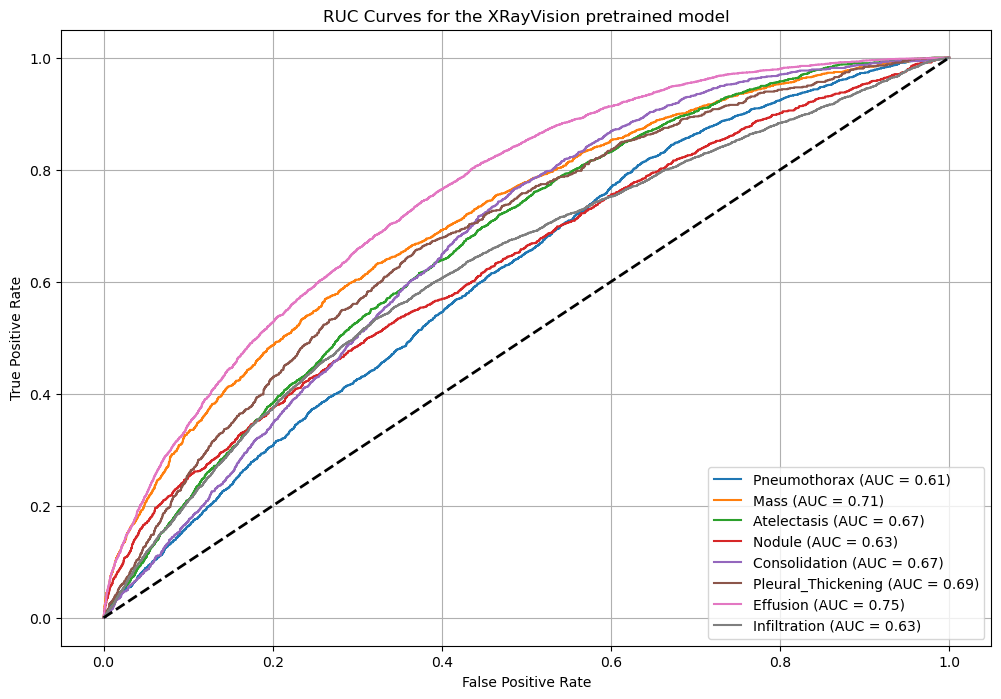

In [60]:
# Apply sigmoid to get probabilities
probs_array = np.array(probs_list, dtype=object)
labels_array = np.array(labels_list, dtype=object)
preds = (probs_array > 0.5).astype(int)
# %% [markdown]
# ## Metrics on Test Set

y_true = labels_array.astype(int)
y_pred = preds.astype(int)

print("\nClassification Report (Per-Class):")
print(
    classification_report(
        y_true, y_pred, 
        target_names=[df_test.columns.tolist()[1:][i] for i in range(y_true.shape[1])]
    )
)

# Confusion matrix (argmax at the row level can be misleading for multi-label,
# but shown here for demonstration.)
cm = confusion_matrix(
    y_true.argmax(axis=1), 
    y_pred.argmax(axis=1)
)
print("\nConfusion Matrix:\n", cm)

# %% [markdown]
# ## ROC Curves (Optional)

plt.figure(figsize=(12, 8))
for i in range(y_true.shape[1]):
    fpr, tpr, _ = roc_curve(y_true[:, i], probs_array[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{df_test.columns.tolist()[1:][i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RUC Curves for the XRayVision pretrained model')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig("AUC, the XRayVision pretrained model.pdf")
plt.show()


In [91]:
probs

array([[0.58126178, 0.51390445, 0.6223327 , ..., 0.54174457, 0.62386541,
        0.6263456 ],
       [0.63038038, 0.62834573, 0.64238543, ..., 0.62788315, 0.6392039 ,
        0.64883026],
       [0.64786047, 0.62415959, 0.64013322, ..., 0.62575607, 0.66608937,
        0.64425058],
       ...,
       [0.50224643, 0.50040582, 0.50098186, ..., 0.50000295, 0.50009833,
        0.51248682],
       [0.5034019 , 0.50351961, 0.52433262, ..., 0.50001592, 0.50138053,
        0.5475505 ],
       [0.55683451, 0.53933975, 0.52842249, ..., 0.50283489, 0.5107445 ,
        0.5270833 ]])

In [ ]:
np.unique(all_probs>0)


array([False])